# Breast Cancer Classification Analysis

In [13]:
#Loading the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, accuracy_score , mean_squared_error, r2_score
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
#Reading the dataset
data = pd.read_csv("Cancer.csv")
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

### Data Exploration and Visualisation

In [62]:
# Display first six observations
data.head()

# Check the structure of the data
print(data.info())

# Display the summary of the data
print(data.describe(include='all'))

# Display the unique values of the Purchase variable
print(data['diagnosis'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [10]:
data.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

C:\Users\SANTOSH VIJAYVARGIA\AppData\Local\Temp\ipykernel_13112\1374904731.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data['diagnosis'], y=data['radius_mean'], palette=Diagnosis_color)


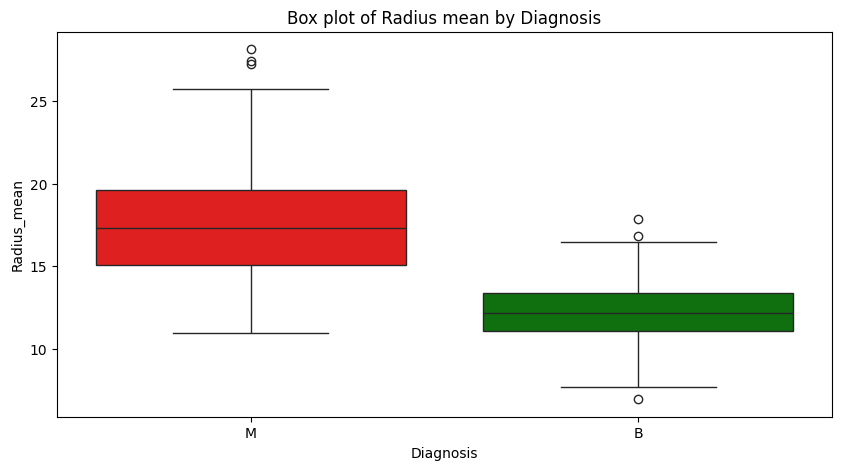

In [13]:
# Correct the capitalization in the diagnosis_color dictionary
Diagnosis_color = {"M": "red", "B": "green"}

# Box plot for log-transformed Radius_mean by Diagnosis
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['diagnosis'], y=data['radius_mean'], palette=Diagnosis_color)
plt.xlabel("Diagnosis")
plt.ylabel("Radius_mean")
plt.title("Box plot of Radius mean by Diagnosis")
plt.show()




The graph shows presence of some outliers exist in the malignant and benign diagnosis groups. The median radius mean is hugher for patients with malignant diagnosis than for the patients with benign diagnosis. The spread of radius mean is much wider for the patients with malignant diagnosis than for the patients with benign diagnosis.

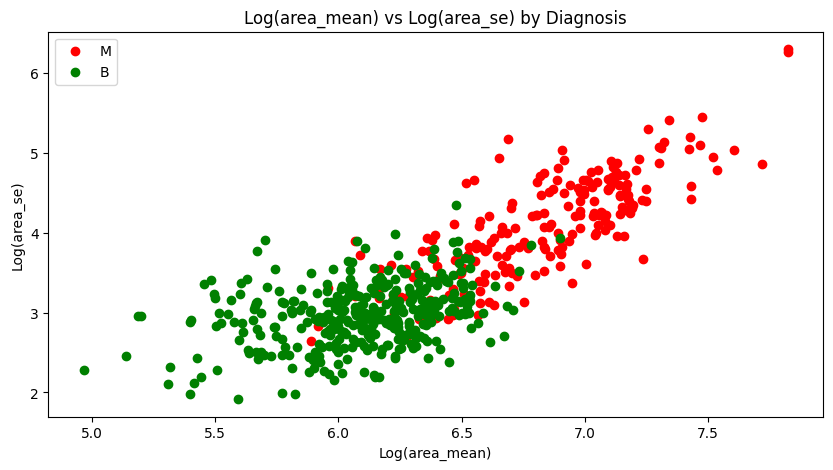

In [15]:
# Plot log(area_mean) against log(area_se) colored by diagnosis using the corrected color mapping
plt.figure(figsize=(10, 5))
for diagnosis, color in Diagnosis_color.items():
    subset = data[data['diagnosis'] == diagnosis]
    plt.scatter(np.log(subset['area_mean']), np.log(subset['area_se']), color=color, label=diagnosis)
plt.xlabel("Log(area_mean)")
plt.ylabel("Log(area_se)")
plt.title("Log(area_mean) vs Log(area_se) by Diagnosis")
plt.legend()
plt.show()

There is a positive correlation between log(area_mean) and log(area_se), which means a sthe average area of the tumor increases the average standard error also increases. Malignant tumors tend to have larger areas and higher standard errors than bening tumors.

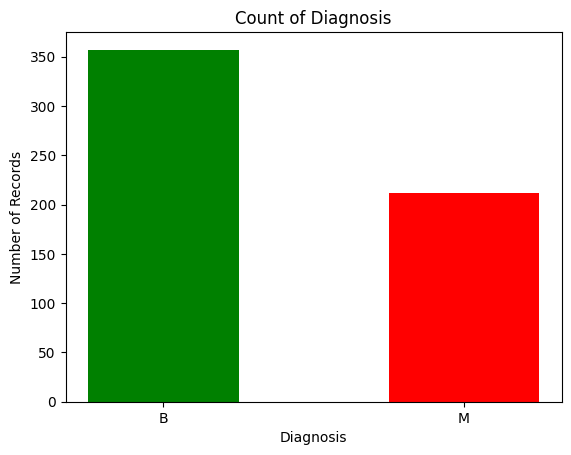

In [21]:
#Ploting the number of malignant and benign records in the data set
Diagnosis_color_list = [Diagnosis_color[label] for label in count_diagnosis.index]

count_diagnosis = data["diagnosis"].value_counts()

plt.bar(count_diagnosis.index, count_diagnosis.values, color = Diagnosis_color_list, width = 0.5)
plt.xlabel("Diagnosis")
plt.ylabel("Number of Records")
plt.title("Count of Diagnosis")
plt.show()

The above chart shows that our data contains more cases of benign breast cancers than malignant breast cancers

Text(0.5, 1.0, ' Texture Mean Distribution')

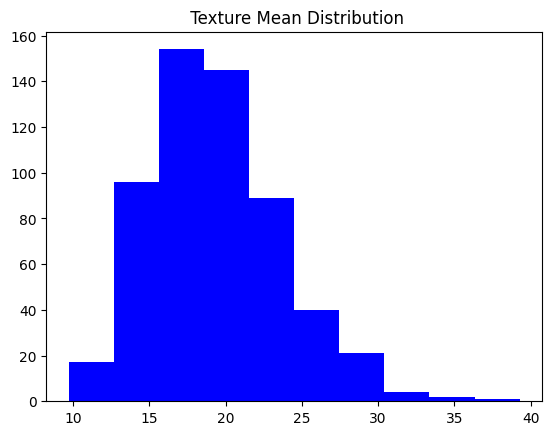

In [26]:
#Plotting histograms to understand the distribution of the data
plt.hist(data["texture_mean"], color = 'blue', bins = 10)
plt.title(" Texture Mean Distribution")



The chart shows that the texture mean data is slightly right skewed and maximum data is lies between 15-20units


Text(0.5, 1.0, ' Perimeter Mean Distribution')

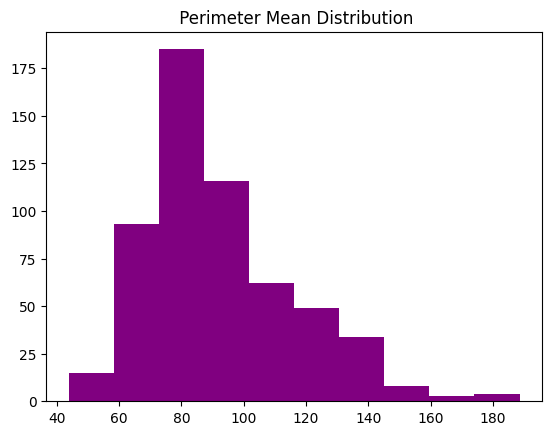

In [25]:
#Plotting histograms to understand the distribution of the data
plt.hist(data["perimeter_mean"], color = 'purple', bins = 10)
plt.title(" Perimeter Mean Distribution")

The above chart shows that the perimeter mean data is slightly right 
skewed around the mean of 80 units.

Text(0.5, 1.0, 'Smoothness Mean Distribution')

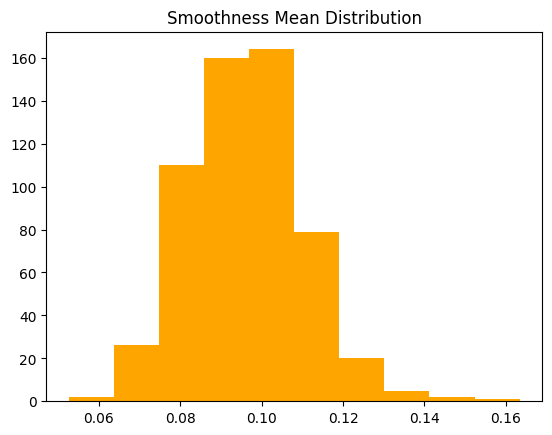

In [29]:
#Plotting histograms to understand the distribution of the data
plt.hist(data["smoothness_mean"], color = 'orange', bins = 10)
plt.title("Smoothness Mean Distribution")

The above chart shows that the smoothness mean is normally distributed aroudn the mean of 0.10 units approx.


### Logistic Regression Model Development

In [3]:
#Converting the categorical variable into binary: 1 for malignant and 0 for bening
data['diagnosis'] = data['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)
print(data)

           id  diagnosis  radius_mean  texture_mean  perimeter_mean  \
0      842302          1        17.99         10.38          122.80   
1      842517          1        20.57         17.77          132.90   
2    84300903          1        19.69         21.25          130.00   
3    84348301          1        11.42         20.38           77.58   
4    84358402          1        20.29         14.34          135.10   
..        ...        ...          ...           ...             ...   
564    926424          1        21.56         22.39          142.00   
565    926682          1        20.13         28.25          131.20   
566    926954          1        16.60         28.08          108.30   
567    927241          1        20.60         29.33          140.10   
568     92751          0         7.76         24.54           47.92   

     area_mean  smoothness_mean  compactness_mean  concavity_mean  \
0       1001.0          0.11840           0.27760         0.30010   
1       1

C:\Users\SANTOSH VIJAYVARGIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\SANTOSH VIJAYVARGIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
C:\Users\SANTOSH VIJAYVARGIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +


-0.22569204540387156


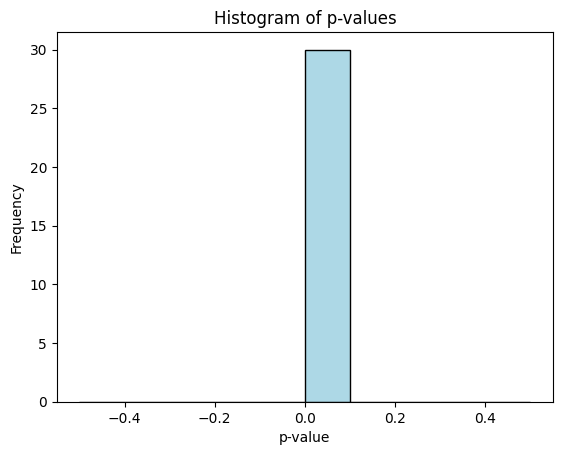

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Logistic regression using GLM model
X = data.drop(["diagnosis","id"],axis=1)
X = sm.add_constant(data.drop(['diagnosis', 'id'], axis=1))
Y = data["diagnosis"]

# Fit the GLM model
GLM_model = sm.GLM(Y, X, family=sm.families.Binomial())
result = GLM_model.fit(max_iter = 10000)
result.summary()

# Calculate the R^2 value
r_squared = 1 - (result.deviance / result.null_deviance)
print(r_squared)

# Plot the histogram of p-values
p_values_glm = result.pvalues[1:]
plt.hist(p_values_glm, color="lightblue", edgecolor="black")
plt.xlabel("p-value")
plt.ylabel("Frequency")
plt.title("Histogram of p-values")
plt.show()



In [9]:
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              diagnosis   No. Observations:                  569
Model:                            GLM   Df Residuals:                      538
Model Family:                Binomial   Df Model:                           30
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 24 Jan 2024   Deviance:                       921.03
Time:                        21:13:32   Pearson chi2:                 4.50e+16
No. Iterations:                    33   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

The above model results in a negative r square. The histogram also shows that the model is a misfit. So next we checked for multicollinearity. We calculated VIF for the variables and drop the ones which have a score of more than 10.

     const  texture_se  area_se  smoothness_se  concavity_se  symmetry_se  \
0      1.0      0.9053   153.40       0.006399       0.05373      0.03003   
1      1.0      0.7339    74.08       0.005225       0.01860      0.01389   
2      1.0      0.7869    94.03       0.006150       0.03832      0.02250   
3      1.0      1.1560    27.23       0.009110       0.05661      0.05963   
4      1.0      0.7813    94.44       0.011490       0.05688      0.01756   
..     ...         ...      ...            ...           ...          ...   
564    1.0      1.2560   158.70       0.010300       0.05198      0.01114   
565    1.0      2.4630    99.04       0.005769       0.03950      0.01898   
566    1.0      1.0750    48.55       0.005903       0.04730      0.01318   
567    1.0      1.5950    86.22       0.006522       0.07117      0.02324   
568    1.0      1.4280    19.15       0.007189       0.00000      0.02676   

     fractal_dimension_se  concavity_worst  
0                0.006193     

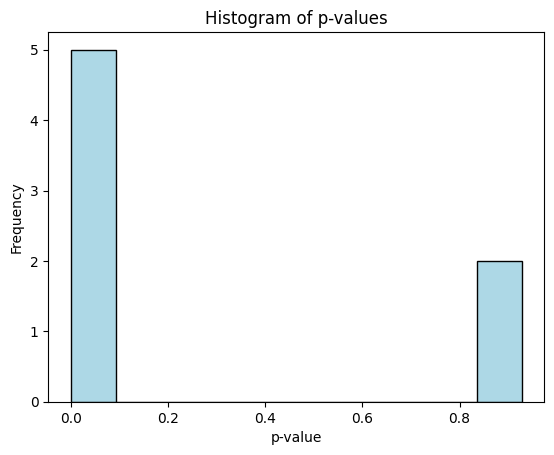

In [14]:
# functions to get the VIF for each variables and dropping the ones with VIF greater than 10
def calculate_vif(dataframe):
    vif_df = pd.DataFrame()
    vif_df['Variable'] = dataframe.columns
    vif_df['VIF'] = [variance_inflation_factor(dataframe.values, idx) for idx in range(dataframe.shape[1])]
    return vif_df

def reduce_multicollinearity(dataframe, vif_threshold=10):
    while True:
        vif_table = calculate_vif(dataframe)
        highest_vif = vif_table['VIF'].max()
        if highest_vif > vif_threshold:
            highest_vif_feature = vif_table[vif_table['VIF'] == highest_vif]['Variable'].iloc[0]
            dataframe.drop(columns=[highest_vif_feature], inplace=True)
        else:
            break
    return dataframe

# x vairables left after using the function reduce_multicollinearity
X = data.drop(['diagnosis', 'id'], axis=1)
X_reduced = sm.add_constant(reduce_multicollinearity(X, vif_threshold=10))

#X_reduced = sm.add_constant(X_reduced)
print(X_reduced)

# the y response
y = data['diagnosis']

# Fit the GLM model
reduced_glm = sm.GLM(y, X_reduced, family=sm.families.Binomial()).fit()

# Print the summary
print(reduced_glm.summary())

# Calculate the R^2 value
r_squared = 1 - (reduced_glm.deviance / reduced_glm.null_deviance)
print(f'The R^2 for the reduced model is: {r_squared}')

# display the p-values
reduced_p_values = reduced_glm.pvalues[1:]

# Plot the histogram of p-values
plt.hist(reduced_p_values, color="lightblue", edgecolor="black")
plt.xlabel("p-value")
plt.ylabel("Frequency")
plt.title("Histogram of p-values")
plt.show()

### Model Evaluation

For question 3 we split the data into train and test before we run logistic regression using GLM model. Then we calculate the RMSE, R2 and accuracy for model evaluation.

In [17]:
#Split the data into train and test
#x_train, y_train is the 70% of the whole dataset that will be used to traint the model
#x_test, y_test is the 30% of the whole dataset that will be used to test the model
x_train, x_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.30, random_state = 15)

Trained_glm_model = sm.GLM(y_train, x_train, family=sm.families.Binomial()).fit()
print(Trained_glm_model.summary())

r_squared = 1 - (Trained_glm_model.deviance / Trained_glm_model.null_deviance)
print(f"R^2 of the cut model with the significant variables is: {r_squared}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:              diagnosis   No. Observations:                  398
Model:                            GLM   Df Residuals:                      390
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32.954
Date:                Wed, 24 Jan 2024   Deviance:                       65.908
Time:                        21:58:41   Pearson chi2:                     105.
No. Iterations:                    10   Pseudo R-squ. (CS):             0.6855
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -14.4948 

In [20]:
y_pred_prob = Trained_glm_model.predict(x_test)
y_pred = np.round(y_pred_prob)

test_r_squared = r2_score(y_test, y_pred)
print(f"R-squared of the Test Data: {test_r_squared}")

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model: {accuracy}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred_prob))
print(f"RMSE of the model: {rmse}")

R-squared of the Test Data: 0.6984126984126984
Accuracy of the model: 0.9298245614035088
RMSE of the model: 0.22923041048076082


1. The R-squared value of 0.698 suggests that the model explains the 69.8% of the variance in the target variables (diagnosis). It suggests a moderate level of explanatory power. It suggests that the model captures a decent proportion of the factors influencing malignant behaviour.
2. The Accuracy of 0.929 means the model correctly classifies the 93% of the cases in the dataset. Its a high level of accuracy, suggesting that the model correctly distinguishes between malignant and benign cases
3. The RMSE value of 0.229 calculates the avarage difference between the predicted values and the actual values. A lower RMSE indicates better fit.Here the lowere RMSE further suggests that the model's prediction are close to true value.
Accordign to these parameters the model seems to be good enough to predict the true values.

### Testing Interactions between features

In [21]:
import statsmodels.formula.api as smf

data['diagnosis_x_radius'] = data['diagnosis'] * data['radius_mean']
data['diagnosis_x_texture'] = data['diagnosis'] * data['texture_mean']

reg = smf.ols(formula='diagnosis ~ radius_mean + texture_mean + diagnosis_x_radius + diagnosis_x_texture', data=data).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:              diagnosis   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     8648.
Date:                Wed, 24 Jan 2024   Prob (F-statistic):               0.00
Time:                        22:52:13   Log-Likelihood:                 781.81
No. Observations:                 569   AIC:                            -1554.
Df Residuals:                     564   BIC:                            -1532.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.4197    

#### Interpretation
The interaction terms tell us how the effect texture_mean and radius_mean on diagnosis changes depending on the value of diagnosis. Positive coefficient for radius_mean indicates that higher radius_mean value increases the probability of being diagnosed with cancer, more for malignant cases than for benign casee. Similarly, positive coefficient for texture mean and diagnossis indicates higher texture values increase the probability fo being diagnosed with cancer more for benign than for malignant cases.

#### Issues that occur when using a linear regression model to predict binary outcomes: 
Linearity assumptions are violated when we use a linear regression model to predict a binary variable. The binary predictor variable often assume heteroscedasticity, violating assumptions of linear regression model. The binary outcomes are also non-linear in nature, violating anotehr assumption of linear regression modeling.

### Feature Selection and Cross Validation : Full vs Reduced Model

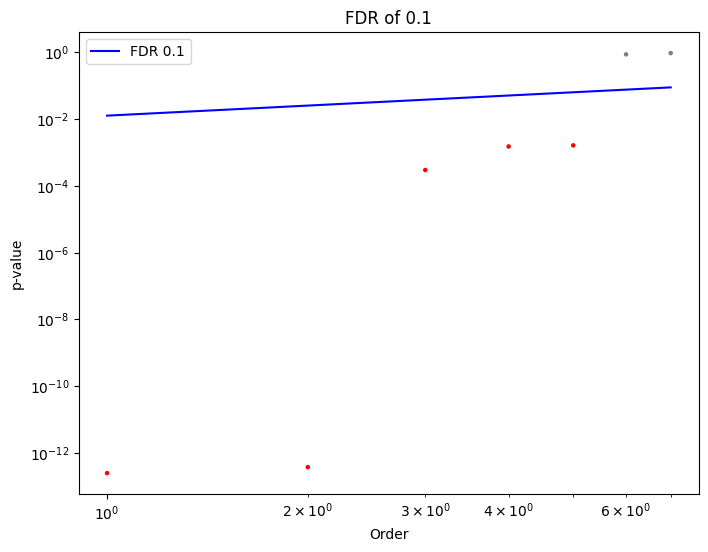

Threshold p-value at 10% FDR: 0.0016


In [23]:
#Using FDR to identify subset of significant predictors
def fdr_cut(pvals, q=0.1):
    
    # Sort p-values and remove NaNs
    pvals = sorted([p for p in pvals if not pd.isna(p)])
    N = len(pvals)
    k = np.arange(1, N + 1)
    alpha = max(p for p, rank in zip(pvals, k) if p <= q * rank / (N + 1))

    # Plot the p-values
    plt.figure(figsize=(8, 6))
    plt.scatter(k, pvals, c=['gray' if p > alpha else 'red' for p in pvals], s=5)
    plt.plot(k, q * k / (N + 1), color='blue', label=f'FDR {q}')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Order")
    plt.ylabel("p-value")
    plt.title(f"FDR of {q}")
    plt.legend()
    plt.show()

    return alpha

# Apply the function on the extracted p-values
threshold = fdr_cut(reduced_p_values)
print(f"Threshold p-value at 10% FDR: {threshold:.4f}")


In [38]:
# Identify significant predictors based on the threshold p-value
significant_predictors = reduced_p_values[reduced_p_values <= 0.0016].index.tolist()

# Include the dependent variable 'FAIL' in the selected columns
selected_columns = ['diagnosis'] + significant_predictors

# Prepare the data for the new model
X_cut = data[selected_columns].drop('diagnosis', axis=1)
X_cut = sm.add_constant(X_cut)  # Add a constant (intercept) to the predictors
y_cut = data['diagnosis']

# Fit the new GLM model using only the significant predictors
cut_model = sm.GLM(y_cut, X_cut, family=sm.families.Binomial()).fit()

# Calculate the R^2 value for the new model
r_squared_cut = 1 - (cut_model.deviance / cut_model.null_deviance)

print(f"R^2 value for the new model: {r_squared_cut:.4f}")
print(significant_predictors)

R^2 value for the new model: 0.8226
['area_se', 'concavity_se', 'fractal_dimension_se', 'concavity_worst']


#### Compare the full model vs reduced model

In [26]:
# Define the R2 function and deviance as described before
def deviance(y, pred, family="gaussian"):
    if family == "gaussian":
        return np.sum((y - pred) ** 2)
    elif family == "binomial":
        y = np.array(y)
        pred = np.array(pred)
        return -2 * np.sum(y * np.log(pred) + (1 - y) * np.log(1 - pred))

def R2(y, pred, family="gaussian"):
    dev_val = deviance(y, pred, family=family)
    dev0 = deviance(y, [np.mean(y)] * len(y), family=family)
    return 1 - dev_val / dev0


In [32]:
import statsmodels.api as sm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
# Setup the experiment
n = len(data)
K = 10
foldid = np.tile(np.arange(1, K+1), int(np.ceil(n/K)))[:n]
np.random.shuffle(foldid)

# Empty lists to store results
OOS_full = []
OOS_cut = []

# Get the significant names
signif_names = significant_predictors.index  # Assuming signif is a DataFrame or Series with column names as index

for k in range(1, K+1):
    train_idx = np.where(foldid != k)[0]
    test_idx = np.where(foldid == k)[0]

    # Full model
    X_full_train = sm.add_constant(data.drop('diagnosis', axis=1).iloc[train_idx])
    y_train = data['diagnosis'].iloc[train_idx]
    rfull = sm.GLM(y_train, X_full_train, family=sm.families.Binomial()).fit()

    # Cut model
    X_cut_train = sm.add_constant(data[['diagnosis'] + significant_predictors].iloc[train_idx].drop('diagnosis', axis=1))
    rcut = sm.GLM(y_train, X_cut_train, family=sm.families.Binomial()).fit()

    # Predictions
    X_full_test = sm.add_constant(data.drop('diagnosis', axis=1).iloc[test_idx])
    pred_full = rfull.predict(X_full_test)

    # Corrected
    X_cut_test = sm.add_constant(data[['diagnosis'] + significant_predictors].iloc[test_idx].drop('diagnosis', axis=1))
    pred_cut = rcut.predict(X_cut_test)

    # Calculate R2 and store
    y_test = data['diagnosis'].iloc[test_idx]
    OOS_full.append(R2(y_test, pred_full, family="binomial"))
    OOS_cut.append(R2(y_test, pred_cut, family="binomial"))

 


C:\Users\SANTOSH VIJAYVARGIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\SANTOSH VIJAYVARGIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\SANTOSH VIJAYVARGIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\SANTOSH VIJAYVARGIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\gen

In [33]:
OOS_full


[nan,
 0.9999999998614174,
 nan,
 0.9999999995512084,
 0.9999999999750743,
 nan,
 0.9999999999953156,
 0.9999999997846468,
 0.9999999999924679,
 0.9999999999859649]

In [34]:
OOS_cut

[0.8324731052701275,
 0.883438670428944,
 nan,
 nan,
 nan,
 0.9055142341177488,
 0.4881865982362106,
 0.7050206613252883,
 0.7990129122248106,
 nan]

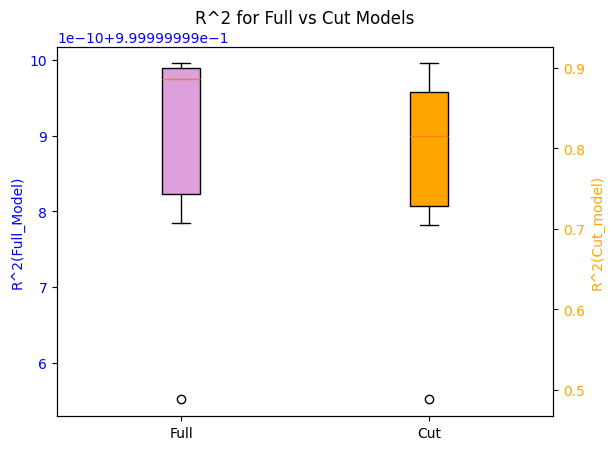

In [46]:
# Cleaning OOS_full
OOS_full_cleaned = [value for value in OOS_full if not np.isinf(value) and not np.isnan(value)]
OOS_cut = [value for value in OOS_cut if not np.isinf(value) and not np.isnan(value)]

#Plotting the box plot for R square values of Out of sample(OOS) full model and Out of sample(OOS) reduced model. 
#Since the OOS_full_model has a different scale than OOS_cut model, we have used a secondary axis so that both box plots can be analysed properly.
fig, ax1 = plt.subplots()

#Plotting the subplot for OOS_full_cleaned
ax1.boxplot([OOS_full_cleaned], positions = [1], labels=['Full'], patch_artist=True, boxprops=dict(facecolor="plum"))
ax1.set_ylabel("R^2(Full_Model)",color = "blue")
ax1.tick_params(axis = 'y', labelcolor = 'blue')

#Creating a secondary y axis
ax2 = ax1.twinx()
ax2.boxplot([OOS_cut], positions = [2], labels=['Cut'], patch_artist=True, boxprops=dict(facecolor="orange"))
ax2.set_ylabel("R^2(Cut_model)",color = "orange")
ax2.tick_params(axis = 'y', labelcolor = 'orange')

plt.xlabel('Model')
plt.title('R^2 for Full vs Cut Models')
plt.show()


From the above chart we can interpret the following:
1. Full Model has its R2 median near 1 , indicating very high predictive preference.The graph shows a few outliers in the lower R2 level, but overall the R2 value is clustered near the mean, which suggests that full model can be highly accurate in some cases and inconsistence in other case.
2. Reduced Model has its meadian R2 near 0.8, indicating a good level of predictive performance with majority of the values tightly clustered near the median and with less variability. Therefoore Reduced model seems to be more stable than Full Model.